# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import pandas as pd
import pickle
import itertools
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
import matplotlib.pyplot as plt
from lib.summary import load_condensed_summary, get_tracing_probability
from matplotlib import colors
import matplotlib
from collections import defaultdict

In [7]:
commithash = 'baf7764'

baseline_colors = ['#31a354', '#74c476'] # '#006d2c',
spect_colors = ['#08519c', '#3182bd', '#6baed6', '#bdd7e7']
pancast_colors = ['#bd0026', '#f03b20', '#fd8d3c', '#fecc5c', '#ffffb2']

In [ ]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

x = list("ABCDEF")
y1, y2 = np.random.randn(2, len(x))
yerr1, yerr2 = np.random.rand(2, len(x))*4+0.3

fig, ax = plt.subplots(figsize=(12,10))

sig_bars = {'rhs_xshift': 0.058, 'height': 0.1, 'ypos': [2.1, 2.2, 2.6, 3, 2.5, 0.9]}


# trans1 = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
# trans2 = ax.transData + ScaledTranslation(+5/72, 0, fig.dpi_scale_trans)
# er1 = ax.errorbar(x, y1, yerr=yerr1, marker="o", linestyle="none", transform=trans1)
# er2 = ax.errorbar(x, y2, yerr=yerr2, marker="o", linestyle="none", transform=trans2)

path_list = [None]*5
for i in range(len(path_list)):
    offset = (len(path_list))/2 * 0.11
    trans = ax.transData + ScaledTranslation(-offset + (i+1/2)/len(path_list) * 2 * offset, 0, fig.dpi_scale_trans)
    er1 = ax.errorbar(x, y1, yerr=yerr1, marker="o", linestyle="none", transform=trans)

for j in range(len(x)):
    for i in range(len(path_list) - 1):
        x1 = j + 0.008
        x2 = j + sig_bars['rhs_xshift']
        y = sig_bars['ypos'][j]
        h = sig_bars['height']
        offset = (len(path_list))/2 * 0.11
        trans = ax.transData + ScaledTranslation(-offset + (i+1/2)/len(path_list) * 2 * offset, 0, fig.dpi_scale_trans)

        plt.plot([x1,x1, x2,x2], [y, y+h, y+h, y], lw=1.0, color='black', transform=trans)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, transform=trans)


plt.show()

# Glance at results

In [ ]:
def show_summary_over_time():
    
    country = 'GER'
    area = 'TU'
    commithash = '43d4464'
    
    
    p_adoption = 1.0
    beacon_proportion = 1.0
    beacon_mode = 'visit_freq'
    show_spect_with_beacons = False
    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    cap = 0.05
    
    
    colors = ['#31a354', '#08519c', '#bd0026', '#f03b20', '#fd8d3c', '#fecc5c', '#ffffb2']
    
    baseline_path = (f'spect-tracing-{country}-{area}-baf7764/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption=0.0'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 f'.pk')
    
    
    paths = [baseline_path]
    titles = ['baseline']
    
    
    
#     paths.append(f'spect-tracing-siteinfo-GER-TU-ac676c1/'
#                 f'spect-tracing-siteinfo-GER-TU'
#                  f'-p_adoption=1.0'
#                  f'-p_recall={p_recall}'
#                  f'-p_manual_reachability={p_manual_reachability}'
#                  f'-delta_manual_tracing={delta_manual_tracing}'
#                  f'-beta_dispersion=10.0-isolation_cap=0.02'
#                  f'-normalization=1.0'
#                 f'.pk')
    
#     paths.append(f'spect-tracing-siteinfo-GER-TU-ac676c1/'
#                 f'spect-tracing-siteinfo-GER-TU'
#                  f'-p_adoption=1.0'
#                  f'-p_recall={p_recall}'
#                  f'-p_manual_reachability={p_manual_reachability}'
#                  f'-delta_manual_tracing={delta_manual_tracing}'
#                  f'-beta_dispersion=10.0-isolation_cap=0.1'
#                  f'-normalization=1.0'
#                 f'.pk')
    
#     paths.append(f'spect-tracing-siteinfo-GER-TU-ac676c1/'
#                 f'spect-tracing-siteinfo-GER-TU'
#                  f'-p_adoption=0.0'
#                  f'-p_recall=0.0-p_manual_reachability=0.0-delta_manual_tracing=0.0'
#                  f'-beta_dispersion=10.0'
#                  f'-isolation_cap=0.0'
#                  f'-normalization=1.5'
#                 f'.pk')
    
#     paths.append(f'spect-tracing-siteinfo-GER-TU-ac676c1/'
#                 f'spect-tracing-siteinfo-GER-TU'
#                  f'-p_adoption=0.0'
#                  f'-p_recall=0.0-p_manual_reachability=0.0-delta_manual_tracing=0.0'
#                  f'-beta_dispersion=10.0'
#                  f'-isolation_cap=0.1'
#                  f'-normalization=1.5'
#                 f'.pk')
    
#     paths.append(f'spect-tracing-siteinfo-GER-TU-ac676c1/'
#                 f'spect-tracing-siteinfo-GER-TU'
#                  f'-p_adoption=0.25'
#                  f'-p_recall=0.0-p_manual_reachability=0.0-delta_manual_tracing=0.0'
#                  f'-beta_dispersion=10.0'
#                  f'-isolation_cap=0.1'
#                  f'-normalization=1.5'
#                 f'.pk')
    
#     paths.append(f'spect-tracing-siteinfo-GER-TU-ac676c1/'
#                 f'spect-tracing-siteinfo-GER-TU'
#                  f'-p_adoption=1.0'
#                  f'-p_recall=0.0-p_manual_reachability=0.0-delta_manual_tracing=0.0'
#                  f'-beta_dispersion=10.0'
#                  f'-isolation_cap=0.1'
#                  f'-normalization=1.5'
#                 f'.pk')
    
    paths.append(f'spect-tracing-siteinfo-GER-TU-e199716/'
                 f'spect-tracing-siteinfo-GER-TU'
                 f'-p_adoption=0.0'
                 f'-p_recall=0.0-p_manual_reachability=0.0-delta_manual_tracing=0.0'
                 f'-beta_dispersion=10.0'
                 f'-isolation_cap=0.1'
                 f'-normalization=1.75'
                '.pk')
    
    
#     paths.append(f'pancast-tracing-siteinfo-{country}-{area}-{commithash}/'
#           f'pancast-tracing-siteinfo-{country}-{area}'
#           f'-p_adoption={p_adoption}'
#           f'-beacon_proportion={beacon_proportion}'
#           f'-beacon_mode={beacon_mode}'
#           f'-p2p_beacon={show_spect_with_beacons}'
#           f'-p_recall={p_recall}'
#           f'-p_manual_reachability={p_manual_reachability}'
#           f'-delta_manual_tracing={delta_manual_tracing}'
#           f'-beta_dispersion=10.0'
#           f'-isolation_cap={cap}.pk')
    
    titles.append('result1')
    titles.append('result2')
    titles.append('result3')
    titles.append('result4')






    
    
    plot_filename = f'test'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=titles,
        quantity='infected',
        mode='total',
        colors=colors,
        ymax=80000,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
# show_summary_over_time()


# Reduction of different quantities compared to baseline

In [5]:
def plot_relative_reduction(*, country, area, mode, ps_adoption, beacon_proportions, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            colors=None, log_yscale=False, figsize=None,
                            isolation_cap=None, ylim=None, box_plot=False, legend_is_left=True,
                            show_significance=None, sig_options=None, commithash=None):
    
    ps_adoption = np.sort(ps_adoption)
    
    if figsize is None:
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
        
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
    delta_manual_tracing = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
    if isolation_cap is not None:
        is_site_info = '-siteinfo'
        extension = (f'-beta_dispersion=10.0'
                    f'-isolation_cap={isolation_cap}'
                    f'-normalization=1.75')
        baseline_extension = (f'-beta_dispersion=10.0'
                    f'-isolation_cap=0.0'
                    f'-normalization=1.75')
    else:
        is_site_info = ''
        extension = ''
        baseline_extension = ''
        

        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.7)
            
    
    plot_filename = (f'comparison{is_site_info}-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-box_plot={box_plot}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    paths = [
                [f'spect-tracing{is_site_info}-{country}-{area}-{commithash}/'
                 f'spect-tracing{is_site_info}-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 f'{extension}'
                 '.pk' for p_adoption in ps_adoption]
            ]
    titles = ['SPECTS']
    
    for beacon_proportion in beacon_proportions:
        paths.append([f'pancast-tracing{is_site_info}-{country}-{area}-{commithash}/'
                      f'pancast-tracing{is_site_info}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'{extension}'
                      '.pk' for p_adoption in ps_adoption])
                     
        titles.append(f'PanCast, beacons at {int(beacon_proportion*100)}\% of sites')
    
    
    if manual_tracing:
        titles.append('Only manual tracing')
    else:
        titles.append('No tracing')
    
    
    if show_spect_with_beacons:
        # titles = [f'SPECTS + beacons at {int(beacon_proportion*100)}\% of sites' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        titles = [f'SPECTS + {int(beacon_proportion*100)}\% beacons' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        new_paths = paths[1:]
        paths = [paths[0]] + new_paths[::-1]
        # colors = ['#377eb8', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
        colors = ['#377eb8', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
        if manual_tracing:
            titles.append('Only manual tracing')
        else:
            titles.append('No tracing')


    if isolation_cap is not None:
        # Always normalize with no MT baseline
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    baseline_path = (f'spect-tracing{is_site_info}-{country}-{area}-{commithash}/'
                     f'spect-tracing{is_site_info}-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'{extension}'
                     f'.pk')

    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   labels=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   box_plot=box_plot,
                                   log_xscale=True,
                                   log_yscale=log_yscale,
                                   ylim=ylim,
                                   show_significance=show_significance,
                                   sig_options=sig_options,
                                   colors=colors,
                                   filename=plot_filename,
                                   figsize=figsize,
                                   figformat='neurips-double',
                                   legend_is_left=legend_is_left)


## Reduction of infections

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
p-value:  0.0
p-value:  0.0
p-value:  0.0
p-value:  0.0006879148033733795
p-value:  0.0
p-value:  0.0
p-value:  2.220446049250313e-15
p-value:  0.06637223832179662
p-value:  0.0
p-value:  0.0
p-value:  4.9887913800006345e-09
p-value:  0.0
p-value:  0.6770447001722859
p-value:  0.0
p-va

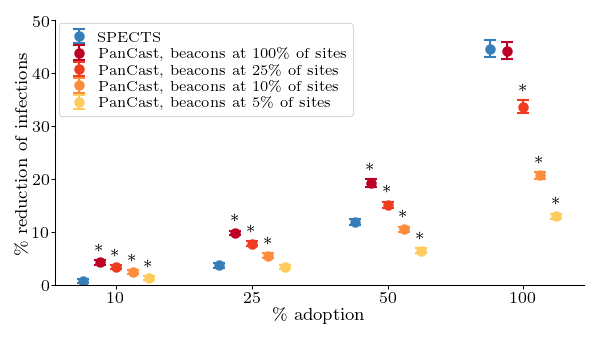

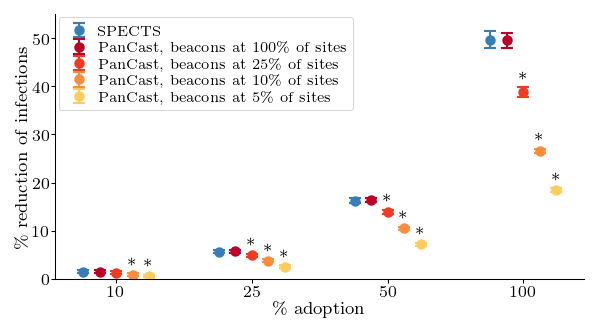

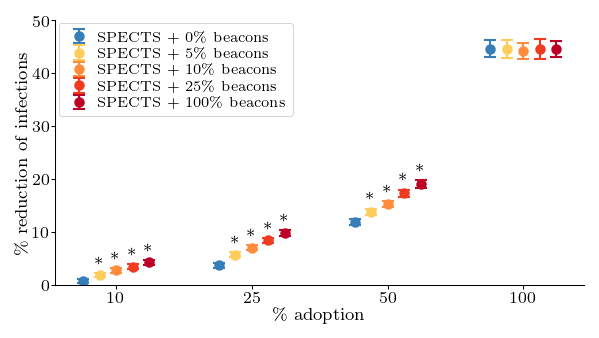

In [20]:
# Main results section, manual tracing panel

LINE_WIDTH = 7.0
COL_WIDTH = 3.333
figsize = (1.2 * LINE_WIDTH / 2, 1.2 * LINE_WIDTH / 3 * 4.5/6)

sig_options={'height': 1.0, 'same_height': False}

plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    beacon_mode='visit_freq',
    manual_tracing=True,
    show_spect_with_beacons=False,
    show_significance='no_bars',
    sig_options=sig_options,
    box_plot=True,
    ylim=[0,50],
    figsize=figsize,
    commithash=commithash
)



# SI results section, manual tracing sensitivity analysis, PanCast, Spects without manual
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    manual_tracing=False,
    show_spect_with_beacons=False,
    show_significance='no_bars',
    sig_options=sig_options,
    box_plot=True,
    ylim=[0,55],
    figsize=figsize,
    commithash=commithash
)

# SI results section, interoperability
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    manual_tracing=True,
    show_spect_with_beacons=True,
    show_significance='no_bars',
    sig_options=sig_options,
    box_plot=True,
    ylim=[0,50],
    figsize=figsize,
    commithash=commithash
)


# DEPRECATED Box plots
# Main results section, environmental information
# for manual_tracing in [True]:#, False]:
#     plot_relative_reduction(
#         country='GER', 
#         area='TU', 
#         mode='cumu_infected',
#         ps_adoption=[1.0, 0.5, 0.25, 0.1],
#         beacon_proportions=[1.0, 0.1, 0.05],
#         isolation_cap=0.1,
#         manual_tracing=manual_tracing,
#         show_spect_with_beacons=False,
#         colors=['#377eb8', '#bd0026', '#fd8d3c', '#fecc5c', '#ffffb2'],
#         ylim=[2.5,105],
#         box_plot=True,
#         log_yscale=False,
#         commithash='e199716'
#     )

## R_eff plots

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

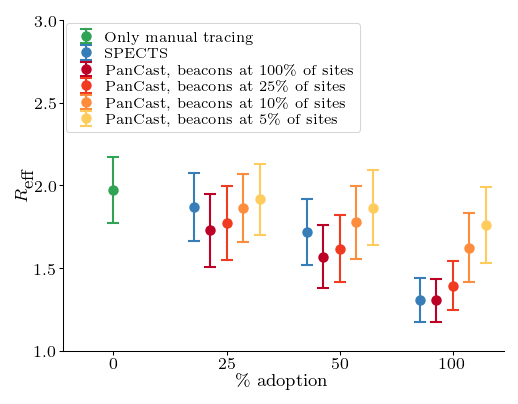

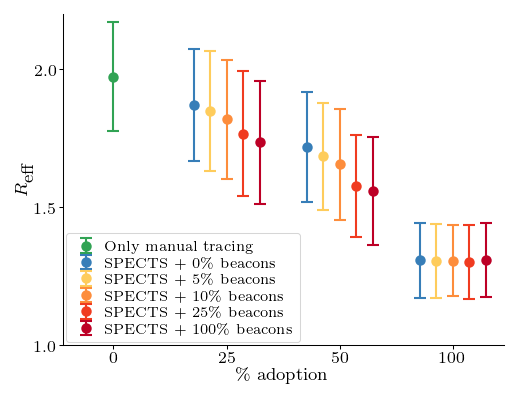

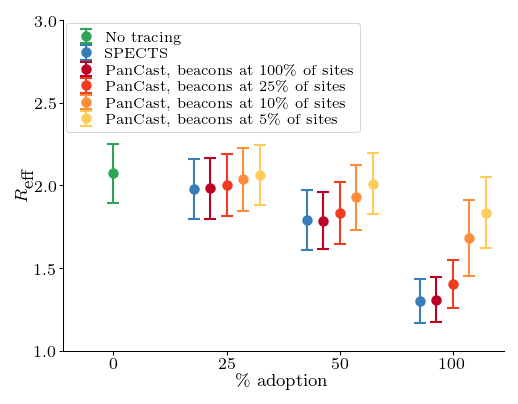

In [21]:
sig_bars = {'lhs_xshift': 0.0, 
            'rhs_xshift': 0.0, 
            'height': 0.07}

LINE_WIDTH = 7.0
COL_WIDTH = 3.333
figsize = (0.5*LINE_WIDTH,  1.5 * LINE_WIDTH / 3 * 4.5/6)


# # # Main results section, manual tracing panel
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='r_eff',
    ps_adoption=[1.0, 0.5, 0.25],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    beacon_mode='visit_freq',
    manual_tracing=True,
    figsize=figsize,
    show_spect_with_beacons=False,
    show_reduction=False,
    ylim = (1.0, 3.0),
    box_plot=True,
    commithash=commithash
)


# # LINE_WIDTH = 7.0
# # COL_WIDTH = 3.333
# # figsize = (0.9* LINE_WIDTH, 1.15* LINE_WIDTH / 3 * 4.5/6)

# # SI results section, interoperability
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='r_eff',
    ps_adoption=[1.0, 0.5, 0.25],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    manual_tracing=True,
    show_spect_with_beacons=True,
    box_plot=True,
    figsize=figsize,
    ylim=[1.0,2.2],
    legend_is_left='outside',
    show_reduction=False,
    commithash=commithash
)

# SI results section, manual tracing sensitivity analysis, PanCast, Spects without manual
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='r_eff',
    ps_adoption=[1.0, 0.5, 0.25],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    beacon_mode='visit_freq',
    manual_tracing=False,
    show_spect_with_beacons=False,
    show_reduction=False,
    figsize=figsize,
    ylim = (1.0, 3.0),
    box_plot=True,
    commithash=commithash,
)

## SI: Environmental information, isolation caps

In [ ]:
def plot_relative_reduction_isolation_cap(*, country, area, mode, ps_adoption, beacon_proportion, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            isolation_caps=None, ylim=None, box_plot=False,
                                          commithash=None):
    
    ps_adoption = np.sort(ps_adoption)
    if box_plot:
        LINE_WIDTH = 7.0
        COL_WIDTH = 3.333
        # figsize = (LINE_WIDTH*2/3, COL_WIDTH*2/3)
        figsize = (LINE_WIDTH * 8/12, LINE_WIDTH / 3 * 4.5/6)
    else:
        figsize = lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
    
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    delta_manual_tracing = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.5)
            
    
    plot_filename = (f'comparison-isolation-caps-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-box_plot={box_plot}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    
    
    paths = []
    titles = []
    
    
    for cap in isolation_caps:
        paths.append([f'pancast-tracing-siteinfo-{country}-{area}-{commithash}/'
                      f'pancast-tracing-siteinfo-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'-beta_dispersion=10.0'
                      f'-isolation_cap={cap}'
                      f'-normalization=1.75'
                      '.pk' for p_adoption in ps_adoption])
                     
        #titles.append(f'PanCast, {int(beacon_proportion*100)}\% beacons, isolation budget {int(cap*100)}\%')
        titles.append(f'PanCast ({int(beacon_proportion*100)}\% beacons), isolation budget {int(cap*100)}\%')



        
    for cap in isolation_caps:
        paths.append([f'spect-tracing-siteinfo-{country}-{area}-{commithash}/'
                     f'spect-tracing-siteinfo-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'-beta_dispersion=10.0'
                     f'-isolation_cap={cap}'
                      f'-normalization=1.75'
                     '.pk' for p_adoption in ps_adoption]
                    )
        titles.append(f'SPECTS, isolation budget {int(cap*100)}\%')
        
    baseline_path = (f'spect-tracing-siteinfo-{country}-{area}-{commithash}/'
                     f'spect-tracing-siteinfo-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'#{p_recall}'
                     f'-p_manual_reachability=0.0'#{p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'-beta_dispersion=10.0'
                     f'-isolation_cap=0.0'
                     f'-normalization=1.75'
                     f'.pk')

    
    colors = ['#bd0026', '#f03b20', '#fd8d3c', '#08519c', '#3182bd', '#6baed6', ]
    
    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   labels=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   log_xscale=True,
                                   log_yscale=True,
                                   ylim=ylim,
                                   colors=colors,
                                   box_plot=box_plot,
                                   filename=plot_filename,
                                   figsize=figsize,
                                   figformat='neurips-double',
                                   legend_is_left=True)


    
# SI results section, environmental information, dependence on isolation caps
plot_relative_reduction_isolation_cap(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportion=0.25,
    isolation_caps=[0.1, 0.05, 0.02],
    ylim=[2.5,100],
    box_plot=True,
    manual_tracing=False,
    commithash='e199716'
)

In [56]:
!bash crop_pdfs.sh plots/comparison-*.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


# Main results: strategic beacon location

In [ ]:
def plot_relative_quantity_heatmap_beacon_mode(*, country, area, mode,
    ps_adoption, beacon_proportions, interpolate, cmap):
    
    filename = (
        f'relative-{mode}-heatmap-pancast'
    )
        
        
    baseline_path = (f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption=0.0'
                 f'-p_recall=0.1'
                 f'-p_manual_reachability=0.5'
                 f'-delta_manual_tracing=0.0'
                 f'.pk')
    
    # pair of list of tuples (x, y, path)
    paths = (
        # spect
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=random'
          f'-p2p_beacon=False'
          f'-p_recall=0.1'
          f'-p_manual_reachability=0.5'
          f'-delta_manual_tracing=0.0'
          f'.pk'))
         
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions],
        
        # pancast
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=visit_freq'
          f'-p2p_beacon=False'
          f'-p_recall=0.1'
          f'-p_manual_reachability=0.5'
          f'-delta_manual_tracing=0.0'
          f'.pk'))
         
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions]
    )

    # plots
    plotter = Plotter()
    plotter.relative_quantity_heatmap(
        xlabel=r'\% sites with beacon',
        ylabel=r'\% adoption',
        path_labels=['placed randomly', 'by integr. visit time'],
        paths=paths, 
        mode=mode,
        zmax=50,
        baseline_path=baseline_path,
        filename=filename, 
#         figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figsize=(4.0, 2.0), 
        figformat='neurips-double',
        interpolate=interpolate,
        width_ratio=1,
        cmap=cmap,
    )

    
for mode in ["cumu_infected"]:
    plot_relative_quantity_heatmap_beacon_mode(
        mode=mode,
        country='GER', 
        area='TU', 
        ps_adoption=[0.1, 0.25, 0.5, 1.0],
        beacon_proportions=[1.0, 0.25, 0.1, 0.05, 0.02],
        interpolate='linear',
        cmap=plt.cm.RdYlGn,
    )
        

In [55]:
!bash crop_pdfs.sh plots/relative-*.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
!!! Error: Input file `plots/relative-*.pdf' not found!


# Quantities over time

## Main results, Manual tracing helps with low adoption

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


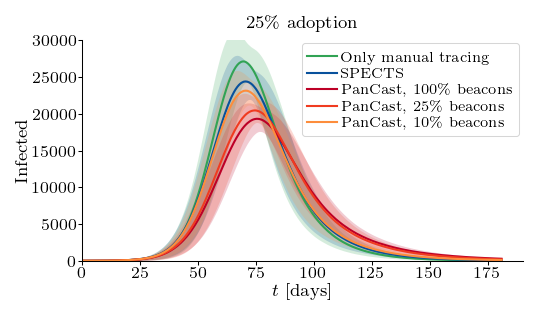

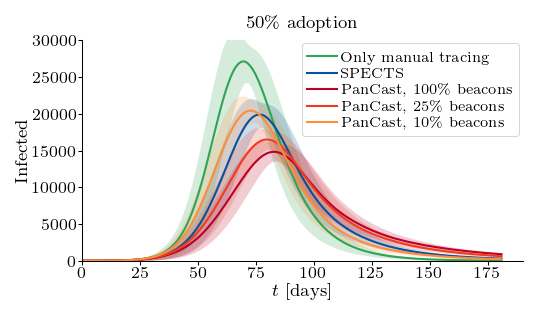

In [138]:
def plot_over_time_section_manual(*, country, area, quantity, mode, beacon_proportions, p_adoption=0.25, ymax, 
                                  rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'
    
    paths = [f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.1'
                     f'-p_manual_reachability=0.5'
                     f'-delta_manual_tracing=0.0'
                     '.pk',
             
             f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 '.pk']
    
    labels = ['Only manual tracing', 'SPECTS']
    colors = [baseline_colors[0], spect_colors[0]]
    
    for i, beacon_proportion in enumerate(beacon_proportions):
        paths.append(f'pancast-tracing-{country}-{area}-{commithash}/'
              f'pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk')
        
        labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons')
        colors.append(pancast_colors[i])
    
    plot_filename = f'{mode}-{quantity}_over_time-main-manual-p_adoption_{p_adoption}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        labels=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        titles=f'{int(p_adoption *100)}\% adoption',
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=False)
    

plot_over_time_section_manual(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=30000,
    p_adoption=0.25,
    beacon_proportions=[1.0, 0.25, 0.1],
    rt_plots=True,
    commithash=commithash
)

plot_over_time_section_manual(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=30000,
    p_adoption=0.5,
    beacon_proportions=[1.0, 0.25, 0.1],
    rt_plots=True,
    commithash=commithash
)

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


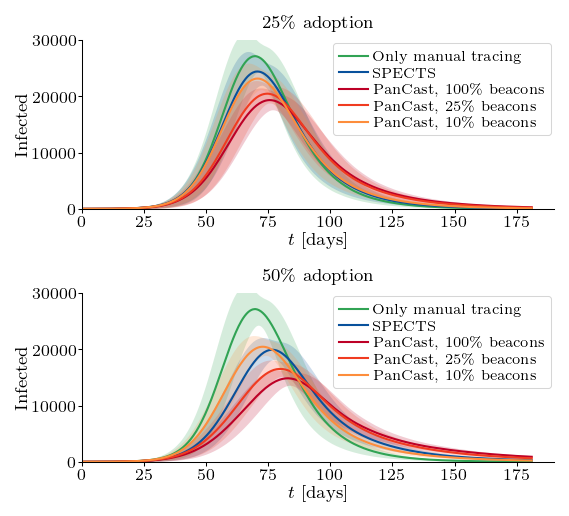

In [108]:
# def plot_over_time_section_manual(*, country, area, quantity, mode, beacon_proportions,
#                                   ps_adoption=0.25, ymax, 
#                                   rt_plots=True, commithash=None):

#     p_recall = 0.1
#     p_manual_reachability = 0.5
#     delta_manual_tracing = 0.0
#     show_spect_with_beacons = False
#     beacon_mode = 'visit_freq'
    
#     pathss = []
    
#     for p_adoption in ps_adoption:
    
#         paths = [f'spect-tracing-{country}-{area}-{commithash}/'
#                          f'spect-tracing-{country}-{area}'
#                          f'-p_adoption=0.0'
#                          f'-p_recall=0.1'
#                          f'-p_manual_reachability=0.5'
#                          f'-delta_manual_tracing=0.0'
#                          '.pk',

#                  f'spect-tracing-{country}-{area}-{commithash}/'
#                      f'spect-tracing-{country}-{area}'
#                      f'-p_adoption={p_adoption}'
#                      f'-p_recall={p_recall}'
#                      f'-p_manual_reachability={p_manual_reachability}'
#                      f'-delta_manual_tracing={delta_manual_tracing}'
#                      '.pk']

#         labels = ['Only manual tracing', 'SPECTS']
#         colors = [baseline_colors[0], spect_colors[0]]

#         for i, beacon_proportion in enumerate(beacon_proportions):
#             paths.append(f'pancast-tracing-{country}-{area}-{commithash}/'
#                   f'pancast-tracing-{country}-{area}'
#                   f'-p_adoption={p_adoption}'
#                   f'-beacon_proportion={beacon_proportion}'
#                   f'-beacon_mode={beacon_mode}'
#                   f'-p2p_beacon={show_spect_with_beacons}'
#                   f'-p_recall={p_recall}'
#                   f'-p_manual_reachability={p_manual_reachability}'
#                   f'-delta_manual_tracing={delta_manual_tracing}'
#                   '.pk')

#             labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons')
#             colors.append(pancast_colors[i])
#         pathss.append(paths)
    
#     plot_filename = f'{mode}-{quantity}_over_time-main-manual'
#     plotter = Plotter()

    
#     titles = [f'{int(p_adoption *100)}\% adoption' for p_adoption in ps_adoption]
#     LINE_WIDTH = 7.0
#     COL_WIDTH = 3.333
#     figsize = (0.55*LINE_WIDTH,  2.0 * LINE_WIDTH / 3 * 4.5/6)
    
#     plotter.compare_quantity(
#         pathss, 
#         labels=labels,
#         titles=titles,
#         quantity=quantity,
#         mode=mode,
#         ymax=ymax,
#         colors=colors,
#         filename=plot_filename, 
#         figsize=figsize, 
#         figformat='neurips-double',
#         legend_is_left=False)
    

# plot_over_time_section_manual(
#     country='GER', 
#     area='TU',
#     quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
#     mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
#     ymax=30000,
#     ps_adoption=[0.25, 0.5],
#     beacon_proportions=[1.0, 0.25, 0.1],
#     commithash=commithash
# )



Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


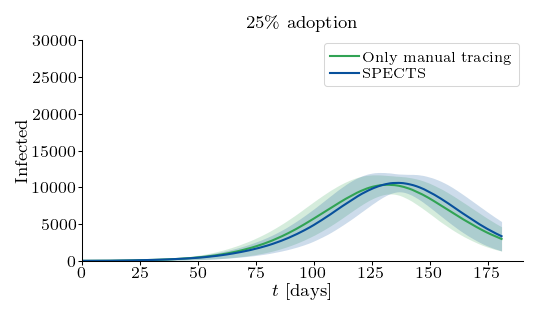

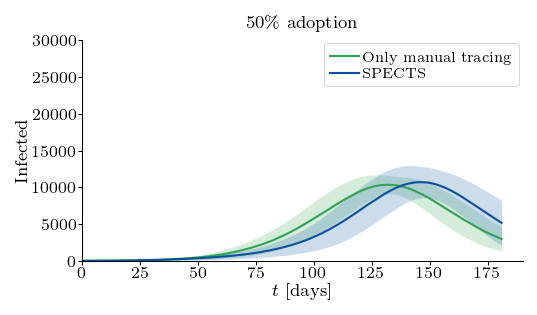

In [9]:
def plot_over_time_section_environmental(*, country, area, quantity, mode, beacon_proportions, p_adoption=0.25, ymax, 
                                  rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'
    isolation_cap =0.1
    
    paths = [f'spect-tracing-siteinfo-{country}-{area}-{commithash}/'
                     f'spect-tracing-siteinfo-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.1'
                     f'-p_manual_reachability=0.5'
                     f'-delta_manual_tracing=0.0'
             f'-beta_dispersion=10.0'
                    f'-isolation_cap={isolation_cap}'
                    f'-normalization=1.75'
                     '.pk',
             
             f'spect-tracing-siteinfo-{country}-{area}-{commithash}/'
                 f'spect-tracing-siteinfo-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
             f'-beta_dispersion=10.0'
                    f'-isolation_cap={isolation_cap}'
                    f'-normalization=1.75'
                 '.pk']
    
    labels = ['Only manual tracing', 'SPECTS']
    colors = [baseline_colors[0], spect_colors[0]]
    
#     for i, beacon_proportion in enumerate(beacon_proportions):
#         paths.append(f'pancast-tracing-siteinfo-{country}-{area}-{commithash}/'
#               f'pancast-siteinfo-tracing-{country}-{area}'
#               f'-p_adoption={p_adoption}'
#               f'-beacon_proportion={beacon_proportion}'
#               f'-beacon_mode={beacon_mode}'
#               f'-p2p_beacon={show_spect_with_beacons}'
#               f'-p_recall={p_recall}'
#               f'-p_manual_reachability={p_manual_reachability}'
#               f'-delta_manual_tracing={delta_manual_tracing}'
#                      f'-beta_dispersion=10.0'
#                     f'-isolation_cap={isolation_cap}'
#                     f'-normalization=1.75'
#               '.pk')
        
#         labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons')
#         colors.append(pancast_colors[i])
    
    plot_filename = f'{mode}-{quantity}_over_time-main-environment-p_adoption_{p_adoption}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        labels=labels,
        titles=f'{int(p_adoption *100)}\% adoption',
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=False)
    

plot_over_time_section_environmental(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=30000,
    p_adoption=0.25,
    beacon_proportions=[1.0, 0.25, 0.1],
    commithash='e199716'
)

plot_over_time_section_environmental(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=30000,
    p_adoption=0.5,
    beacon_proportions=[1.0, 0.25, 0.1],
    commithash='e199716'
)

## SI no manual tracing experiment

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


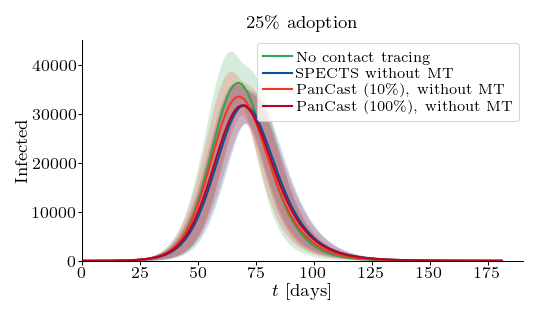

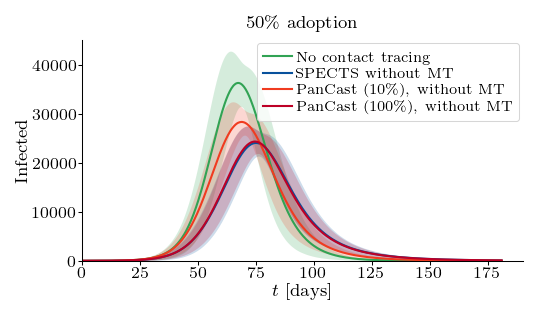

In [44]:
def plot_over_time_si_no_manual(*, country, area, quantity, mode, beacon_proportion, p_adoption=0.25, ymax, 
                                  rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    
    paths = [f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'
                     f'-p_manual_reachability=0.0'
                     f'-delta_manual_tracing=0.0'
                     f'.pk',
             
#              f'spect-tracing-{country}-{area}-{commithash}/'
#                      f'spect-tracing-{country}-{area}'
#                      f'-p_adoption=0.0'
#                      f'-p_recall={p_recall}'
#                      f'-p_manual_reachability={p_manual_reachability}'
#                      f'-delta_manual_tracing={delta_manual_tracing}'
#                      f'.pk',
        
            f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall=0.0'
                 f'-p_manual_reachability=0.0'
                 f'-delta_manual_tracing=0.0'
                 '.pk',
            
#             f'spect-tracing-{country}-{area}-{commithash}/'
#                  f'spect-tracing-{country}-{area}'
#                  f'-p_adoption={p_adoption}'
#                  f'-p_recall={p_recall}'
#                  f'-p_manual_reachability={p_manual_reachability}'
#                  f'-delta_manual_tracing={delta_manual_tracing}'
#                  '.pk',
            
            f'pancast-tracing-{country}-{area}-{commithash}/'
             f'pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall=0.0'
              f'-p_manual_reachability=0.0'
              f'-delta_manual_tracing=0.0'
              '.pk',
             
             
             f'pancast-tracing-{country}-{area}-{commithash}/'
             f'pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion=1.0'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall=0.0'
              f'-p_manual_reachability=0.0'
              f'-delta_manual_tracing=0.0'
              '.pk',
            
#             f'pancast-tracing-{country}-{area}-{commithash}/'
#              f'pancast-tracing-{country}-{area}'
#               f'-p_adoption={p_adoption}'
#               f'-beacon_proportion={beacon_proportion}'
#               f'-beacon_mode={beacon_mode}'
#               f'-p2p_beacon={show_spect_with_beacons}'
#               f'-p_recall={p_recall}'
#               f'-p_manual_reachability={p_manual_reachability}'
#               f'-delta_manual_tracing={delta_manual_tracing}'
#               '.pk'
            ]
    
    labels = ['No contact tracing',
              #'Only manual tracing',
              'SPECTS without MT',
              #'SPECTS with MT',
              f'PanCast ({int(beacon_proportion*100)}\%), without MT',
              f'PanCast (100\%), without MT',
             ]
    
    plot_filename = f'{mode}-{quantity}_over_time-no-manual-tracing-p_adoption_{p_adoption}'
    plotter = Plotter()

    colors = ['g', 'mediumseagreen', spect_colors[0], pancast_colors[0]]
    colors = [baseline_colors[0], spect_colors[0], pancast_colors[1], pancast_colors[0]] 
    
    plotter.compare_quantity(
        paths, 
        labels=labels,
        titles=f'{int(p_adoption *100)}\% adoption',
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=False)
    


plot_over_time_si_no_manual(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=45000, 
    p_adoption=0.25,
    beacon_proportion=0.1,
    commithash=commithash,
    rt_plots=True,
)

plot_over_time_si_no_manual(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=45000, 
    p_adoption=0.5,
    beacon_proportion=0.1,
    commithash=commithash,
    rt_plots=True,
)

## SI: Manual tracing delay

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


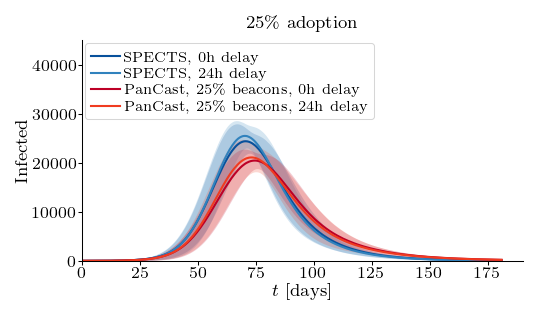

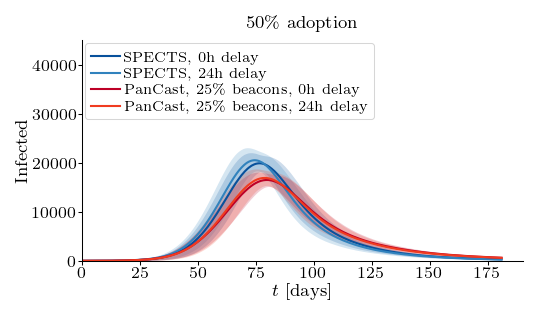

In [12]:
def plot_over_time_si_mt_delay(*, country, area, quantity, mode, manual_tracing_delays,
                               beacon_proportion, p_adoption=0.25, ymax=None, rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    paths = []
    labels = []
    
    for delta_manual_tracing in manual_tracing_delays:
        paths.append(f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     '.pk')
    
        labels.append(f'SPECTS, {int(delta_manual_tracing)}h delay')
    
    for delta_manual_tracing in manual_tracing_delays:
        paths.append(f'pancast-tracing-{country}-{area}-{commithash}/'
              f'pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk')
        
        labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons, {int(delta_manual_tracing)}h delay')
    
    plot_filename = f'{mode}-{quantity}_over_time-manual-delay-p_adoption_{p_adoption}'
    plotter = Plotter()

    colors = [spect_colors[0], spect_colors[1], pancast_colors[0], pancast_colors[1]]
    
    plotter.compare_quantity(
        paths, 
        labels=labels,
        titles=f'{int(p_adoption *100)}\% adoption',
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
    
    
plot_over_time_si_mt_delay(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=45000, 
    manual_tracing_delays=[0.0,24.0],
    p_adoption=0.25,
    beacon_proportion=0.25,
    commithash=commithash,
)

plot_over_time_si_mt_delay(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=45000, 
    manual_tracing_delays=[0.0,24.0],
    p_adoption=0.5,
    beacon_proportion=0.25,
    commithash=commithash,
)

## SI: Interoperability

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


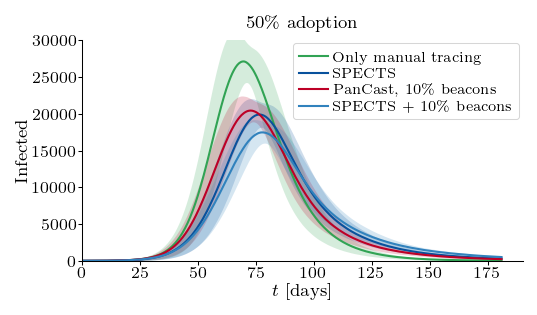

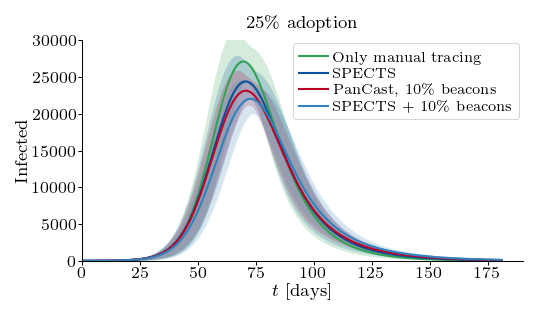

In [38]:
def plot_over_time_si_interoperability(*, country, area, quantity, mode,
                                      beacon_proportion, p_adoption=0.25, ymax=None, rt_plots=True,
                                       commithash=None):


    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    paths = [
        # Baseline with MT
        f'spect-tracing-{country}-{area}-{commithash}/'
         f'spect-tracing-{country}-{area}'
         f'-p_adoption=0.0'
         f'-p_recall={p_recall}'
         f'-p_manual_reachability={p_manual_reachability}'
         f'-delta_manual_tracing={delta_manual_tracing}'
         f'.pk',
        
        # SPECTS
        f'spect-tracing-{country}-{area}-{commithash}/'
         f'spect-tracing-{country}-{area}'
         f'-p_adoption={p_adoption}'
         f'-p_recall={p_recall}'
         f'-p_manual_reachability={p_manual_reachability}'
         f'-delta_manual_tracing={delta_manual_tracing}'
         '.pk',
        
        # PanCast
        f'pancast-tracing-{country}-{area}-{commithash}/'
        f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon=False'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk',
        
        # SPECTS + beacons
        f'pancast-tracing-{country}-{area}-{commithash}/'
        f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon=True'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk',
    ]
    
    labels = ['Only manual tracing',
             'SPECTS',
             f'PanCast, {int(beacon_proportion*100)}\% beacons',
             f'SPECTS + {int(beacon_proportion*100)}\% beacons',
             ]
    
    colors = [baseline_colors[0], spect_colors[0], pancast_colors[0], spect_colors[1]]

    plot_filename = f'{mode}-{quantity}_over_time-interoperability-p_adoption_{p_adoption}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        labels=labels,
        titles=f'{int(p_adoption *100)}\% adoption',
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=False)
    


plot_over_time_si_interoperability(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=30000, 
    p_adoption=0.5,
    beacon_proportion=0.1,
    commithash=commithash,
    rt_plots=True
)

plot_over_time_si_interoperability(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=30000, 
    p_adoption=0.25,
    beacon_proportion=0.1,
    commithash=commithash,
    rt_plots=True
)

In [45]:
# Crop pdf margins
#!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/total-*.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


# R_t over time

Loaded previously extracted data.
Save: plots/rt-main-manual-baseline.pdf
Loaded previously extracted data.
Save: plots/rt-main-manual-SPECTS-p_adoption=0.5.pdf
Loaded previously extracted data.
Save: plots/rt-main-manual-beacons=0.25-p_adoption=0.5.pdf
Loaded previously extracted data.
Save: plots/rt-main-manual-beacons=0.100-p_adoption=0.5.pdf
Loaded previously extracted data.
Save: plots/rt-no-manual-baseline.pdf
Loaded previously extracted data.
Save: plots/rt-no-manual-SPECTS-p_adoption=0.5.pdf
Loaded previously extracted data.
Save: plots/rt-no-manual-beacons=0.25-p_adoption=0.5.pdf
Loaded previously extracted data.
Save: plots/rt-no-manual-beacons=0.100-p_adoption=0.5.pdf
Loaded previously extracted data.
Save: plots/rt-interoperation-baseline.pdf
Loaded previously extracted data.
Save: plots/rt-interoperation-SPECTS-p_adoption=0.5.pdf
Loaded previously extracted data.
Save: plots/rt-interoperation-beacons=0.25-p_adoption=0.5.pdf
Loaded previously extracted data.
Save: plots/rt-

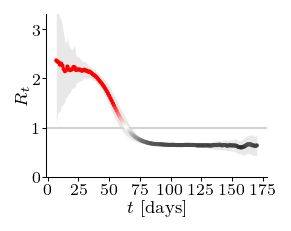

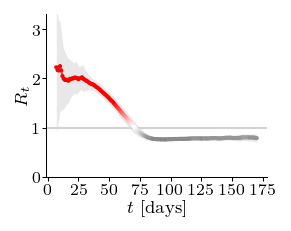

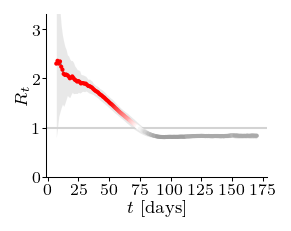

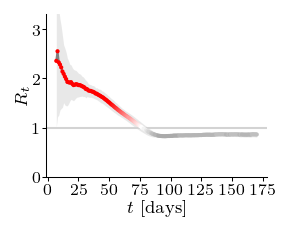

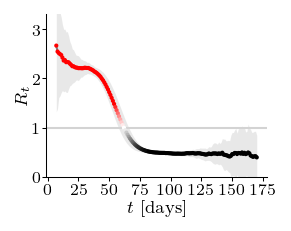

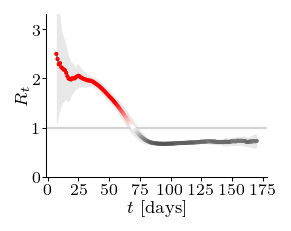

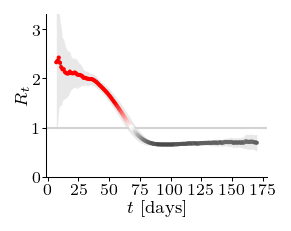

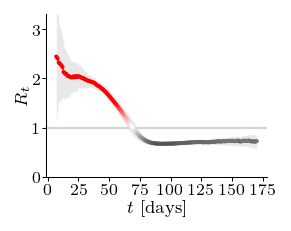

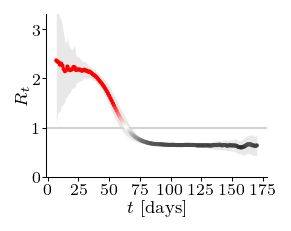

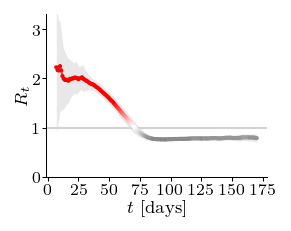

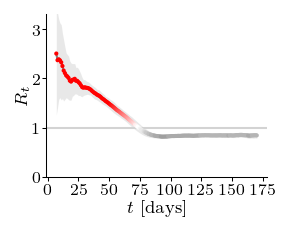

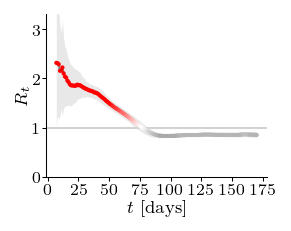

In [44]:
def plot_rt(experiment, p_adoption):
    
    country = 'GER'
    area = 'TU'
    beacon_mode = 'visit_freq'
    
    if experiment == 'no-manual':
        p_recall = 0.0
        p_manual_reachability = 0.0
    else:
        p_recall = 0.1
        p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    
    if experiment == 'interoperation':
        show_spect_with_beacons = True
    else:
        show_spect_with_beacons = False
 
    
    
    paths = [f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing=0.0'
                     '.pk',

             f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 '.pk',

            f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion=0.25'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon={show_spect_with_beacons}'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk',


            f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion=1.0'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon={show_spect_with_beacons}'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk'

            ]
        
    if experiment == 'main-manual':
        labels = [f'Only manual tracing', 
                  f'SPECTS',
                 f'PanCast, 25\% beacons',
                 f'PanCast, 100\% beacons']
    elif experiment == 'no-manual':
        labels = [f'No contact tracing', 
                  f'SPECTS',
                  f'PanCast, 25\% beacons',
                  f'PanCast, 100\% beacons']
    elif experiment == 'interoperation':
        labels = [f'Only manual tracing', 
                  f'SPECTS + 0\% beacons',
                  f'SPECTS + 25\% beacons',
                  f'SPECTS + 100\% beacons']

    
    names = [f'baseline', 
         f'SPECTS-p_adoption={p_adoption}',
         f'beacons=0.25-p_adoption={p_adoption}',
         f'beacons=0.100-p_adoption={p_adoption}',
        ]
    for i, (path, label) in enumerate(zip(paths, labels)):
        
        _, filename = os.path.split(path)
        # plot_filename = 'rt-' + experiment + '-' + filename[:-3]
        plot_filename = 'rt-' + experiment + '-' + names[i]


        # plot
        plotter = Plotter()
        plotter.plot_daily_nbinom_rts(
            path=path, 
            filename=plot_filename,
            cmap_range=(0.5, 1.5),
            figsize=lib_plot.CUSTOM_FIG_SIZE_FULL_PAGE_QUAD,#FIG_SIZE_NEURIPS_TRIPLE,
            figformat='neurips-double',
            ymax=3.3,
            label=labels[i],
            #xlim=(0, 185),
            x_axis_dates=False,
            show_legend=False,
            subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
        )

plot_rt(experiment='main-manual', 
        p_adoption=0.5)

plot_rt(experiment='no-manual', 
        p_adoption=0.5)

plot_rt(experiment='interoperation', 
        p_adoption=0.5)

!bash crop_pdfs.sh plots/rt-*.pdf

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Save: plots/rt-main-manual.pdf
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Save: plots/rt-no-manual.pdf
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Save: plots/rt-interoperation.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


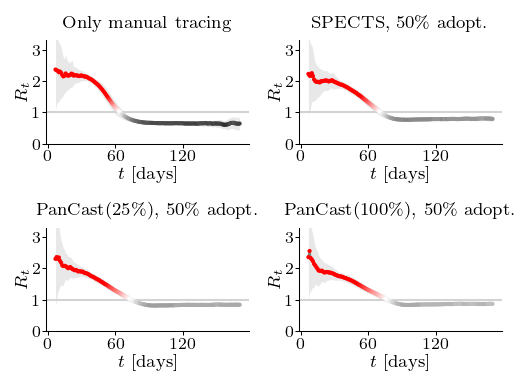

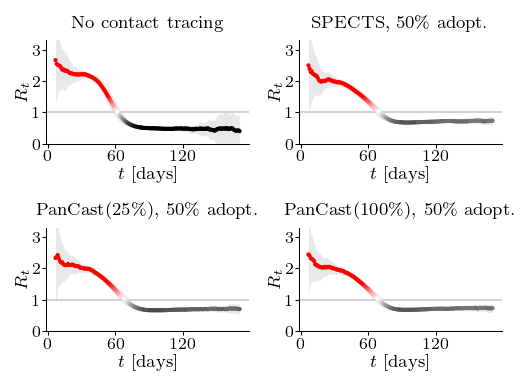

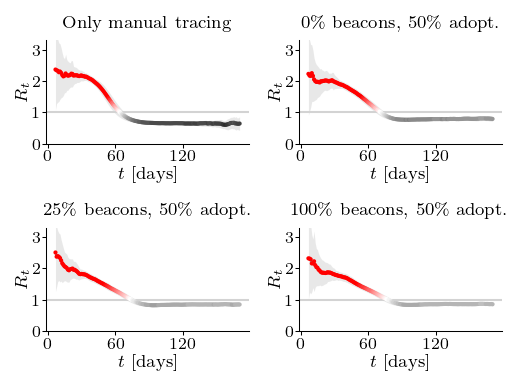

In [144]:
def plot_rt_panel(experiment, p_adoption):
    
    country = 'GER'
    area = 'TU'
    beacon_mode = 'visit_freq'
    
    if experiment == 'no-manual':
        p_recall = 0.0
        p_manual_reachability = 0.0
    else:
        p_recall = 0.1
        p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    
    if experiment == 'interoperation':
        show_spect_with_beacons = True
    else:
        show_spect_with_beacons = False
 
    
    
    paths = [f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing=0.0'
                     '.pk',

             f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 '.pk',

            f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion=0.25'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon={show_spect_with_beacons}'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk',


            f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion=1.0'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon={show_spect_with_beacons}'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk'

            ]
        
    if experiment == 'main-manual':
        labels = [f'Only manual tracing', 
                  f'SPECTS, {int(p_adoption*100)}\% adopt.',
                 f'PanCast(25\%), {int(p_adoption*100)}\% adopt.',
                 f'PanCast(100\%), {int(p_adoption*100)}\% adopt.']
    elif experiment == 'no-manual':
        labels = [f'No contact tracing', 
                  f'SPECTS, {int(p_adoption*100)}\% adopt.',
                  f'PanCast(25\%), {int(p_adoption*100)}\% adopt.',
                  f'PanCast(100\%), {int(p_adoption*100)}\% adopt.']
    elif experiment == 'interoperation':
        labels = [f'Only manual tracing', 
                  f'0\% beacons, {int(p_adoption*100)}\% adopt.',
                  f'25\% beacons, {int(p_adoption*100)}\% adopt.',
                  f'100\% beacons, {int(p_adoption*100)}\% adopt.']

    
    names = [f'baseline', 
         f'SPECTS-p_adoption={p_adoption}',
         f'beacons=0.25-p_adoption={p_adoption}',
         f'beacons=0.100-p_adoption={p_adoption}',
        ]
        
    #_, filename = os.path.split(path)
    plot_filename = 'rt-' + experiment


    LINE_WIDTH = 7.0
    COL_WIDTH = 3.333
    figsize = (0.5*LINE_WIDTH,  1.5 * LINE_WIDTH / 3 * 4.5/6)
    
    
    # plot
    plotter = Plotter()
    plotter.plot_daily_nbinom_rts_panel(
        paths=paths, 
        titles=labels,
        filename=plot_filename,
        cmap_range=(0.5, 1.5),
        figsize=figsize,
        figformat='neurips-double',
        ymax=3.3,
        #xlim=(0, 185),
        x_axis_dates=False,
        show_legend=False,
        subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
    )

plot_rt_panel(experiment='main-manual', 
        p_adoption=0.5)

plot_rt_panel(experiment='no-manual', 
        p_adoption=0.5)

plot_rt_panel(experiment='interoperation', 
        p_adoption=0.5)

!bash crop_pdfs.sh plots/rt-*.pdf

# ROC

None
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Maximum relative % PanCast/SPECT (excluding boundary) tpr 123.7866116677296 bin:  2
Maximum relative % PanCast/SPECT (excluding boundary) prec 124.29351792765921 bin:  2
[0.5, 0.25, 0.1, 0.05]
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Loaded previously extr

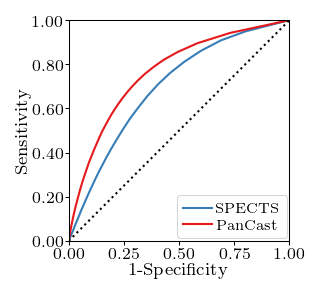

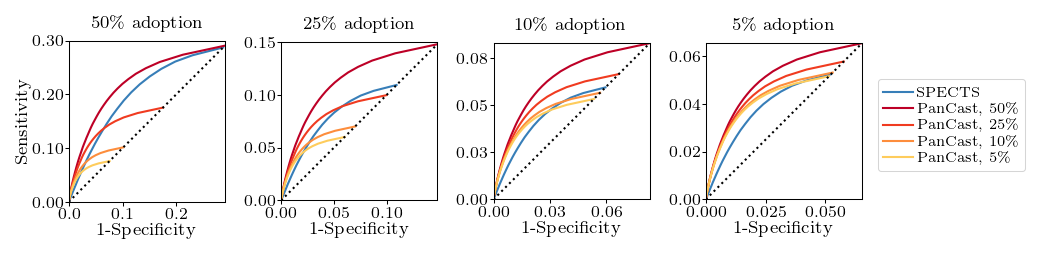

In [38]:
def plot_roc(*, country, area, p_adoption, p_beacon, beta_dispersions, manual_tracing, sitetype=None, 
             multiplot=False, commithash=None):
    
    for beta_dispersion in beta_dispersions:
        path = (f'beacon-environment-{country}-{area}-{commithash}/'
                          f'beacon-environment-{country}-{area}'
                          f'-beacon=all'
                          f'-p_adoption=1.0'
                          f'-beta_dispersion={beta_dispersion}'
                          '.pk')

        if p_adoption is not None:
            if manual_tracing:
                p_manual_reachability = 0.5
                p_recall = 0.1
            else:
                p_manual_reachability = 0.0
                p_recall = 0.0
        else:
            p_manual_reachability = None
            p_recall = None
            p_beacon = None
            p_adoption = [None]

        if multiplot:
            # figsize = (8,3)
            LINE_WIDTH = 7.0
            COL_WIDTH = 3.333
            figsize = (LINE_WIDTH, LINE_WIDTH / 3 * 4.5/6)
            ps_adoption = [p_adoption]
        else:
            # figsize = (2.0, 1.8)
            LINE_WIDTH = 7.0
            COL_WIDTH = 3.333
            figsize = (LINE_WIDTH / 2, 1.15 * LINE_WIDTH / 3 * 4.5/6)
            #figsize = lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
            ps_adoption = p_adoption
            
        for p_adoption in ps_adoption:
            print(p_adoption)
            plot_filename = f'ROC-{country}-{area}-multiplot-{multiplot}-manual-tracing={manual_tracing}-beta-dispersion={beta_dispersion}'
            plotter = Plotter()

            plotter.plot_roc_curve(
                summaries=None,
                paths=[path],
                filename=plot_filename, 
                p_adoption=p_adoption,
                p_manual_reachability=p_manual_reachability,
                p_recall=p_recall,
                p_beacon=p_beacon,
                sitetype=sitetype,
                action='isolate',
                figsize=figsize, 
    #             figsize=(1.8, 1.6), 
                figformat='neurips-double',
                verbose=False,
                use_medical_labels=True)

    
plot_roc(
    country='GER', 
    area='TU', 
    p_adoption=None,
    p_beacon=None,
    sitetype=None,
    beta_dispersions=[10.0],
    manual_tracing=True,
    multiplot=False,
    commithash='43d4464'
)

plot_roc(
    country='GER', 
    area='TU', 
    p_adoption=[0.5, 0.25, 0.1, 0.05],
    p_beacon=[0.5, 0.25, 0.1, 0.05],
    beta_dispersions=[10.0],
    manual_tracing=True,
    multiplot=True,
    commithash='43d4464'
)
    
# # Crop pdf margins
!bash crop_pdfs.sh plots/ROC-*.pdf

In [ ]:
def plot_sens_spec_per_sitetype(beta_dispersion = 10.0, commithash=None):
    summary = load_condensed_summary(f'beacon-environment-GER-TU-{commithash}/'
                              f'beacon-environment-GER-TU'
                              f'-beacon=all'
                              f'-p_adoption=1.0'
                              f'-beta_dispersion={beta_dispersion}'
                              '.pk')
    print()

    tracing_stats = summary['tracing_stats']
    thresholds = list(tracing_stats.keys())
    thres = thresholds[0]

    results = {'sites': defaultdict(lambda: {'fpr': [], 'tpr': []}),
              'no_sites': defaultdict(lambda: {'fpr': [], 'tpr': []})}

    # Compute FPR, TPR
    for sites in ['no_sites', 'sites']:
        for sitetype in tracing_stats[thres].keys():
            for thres in thresholds:
                infected = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean()
                not_infected = tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
                isolated = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
                not_isolated = tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean()
                tpr = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() / infected
                fpr = tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean() / not_infected
                results[sites][sitetype]['fpr'].append(fpr)
                results[sites][sitetype]['tpr'].append(tpr)

    # Plot per site type
    
    LINE_WIDTH = 7.0
    COL_WIDTH = 3.333
    # figsize = (0.9*LINE_WIDTH  ,0.9 * 1.7 * LINE_WIDTH / 3 * 4.5/6)
    figsize = (0.8*LINE_WIDTH  ,0.9 * 1.7 * LINE_WIDTH / 3 * 4.5/6)
    
    fig, ax = plt.subplots(2, 3, figsize=figsize)#(16,1.5))
    
    keys = list(tracing_stats[thres].keys())
    keys = np.roll(keys, 1)
    # keys = ['bus_stop', 'social', 'education', 'office', 'supermarket', 'stats']
    for i, sitetype in enumerate(keys):
        for k, sites in enumerate(['no_sites', 'sites']):
            if sites == 'sites':
                label = 'PanCast'
                color = '#e41a1c'
            else:
                label = 'SPECTS'
                color = '#377eb8'
                
            ax.flat[i].plot(thresholds, 1- np.asarray(results[sites][sitetype]['fpr']), label=label+', specificity', color=color)
            ax.flat[i].plot(thresholds, results[sites][sitetype]['tpr'], label=label+', sensitivity', color=color, linestyle='dashed')
            ax.flat[i].set_xlim([0,0.3])
            title = 'bus stop' if sitetype == 'bus_stop' else sitetype
            title = 'average' if sitetype == 'stats' else title
            # ax.flat[i].set_title(title, fontsize=14)
            ax.flat[i].set_title(title)
            # ax.flat[i].set_xlabel('Tracing threshold', fontsize=11)
            ax.flat[i].set_xlabel('Tracing threshold')
#             if i== 0:
#                 ax.flat[i].legend()
                
    ax[0,2].legend(loc='lower left', bbox_to_anchor=(1.1, 0.18),
                      borderaxespad=0, frameon=True)
#     ax[0,0].legend(loc='lower left', bbox_to_anchor=(-1.1, 0.18),
#                       borderaxespad=0, frameon=True)
#     ax[0, 1].legend(loc='lower left', bbox_to_anchor=(0, 1.1),
#                       borderaxespad=0, frameon=True)
                
    filename = f'site-dependent-characteristics-beta_dispersion={beta_dispersion}'
    plt.tight_layout()
    plt.savefig('plots/' + filename + '.pdf', format='pdf', facecolor=None,
                        dpi=200, bbox_inches='tight')

    

plot_sens_spec_per_sitetype(commithash='43d4464')
# # Crop pdf margins
!bash crop_pdfs.sh plots/site-dependent-*.pdf

# SI: Manual tracing senitivity heatmaps

In [ ]:
def plot_tracing_probability(mode, p_adoption, ps_beacon):
    LINE_WIDTH = 7.0
    COL_WIDTH = 3.333
    figsize = (LINE_WIDTH, LINE_WIDTH / 3 * 4.5/6)
    
    #fig, axs = plt.subplots(1, 1+len(ps_beacon), figsize=(3 * (1 + len(ps_beacon)), 2.5))
    fig, axs = plt.subplots(1, 1+len(ps_beacon), figsize=figsize)
    
    p_recall, p_manually_reachable = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    
    # SPECTS
    p_tracable = get_tracing_probability('SPECTS', p_adoption=p_adoption, p_manual_reachability=p_manually_reachable, p_recall=p_recall)
    c = axs[0].pcolormesh(p_manually_reachable, p_recall, p_tracable, cmap='RdYlGn', vmin=0, vmax=1.0, linewidth=0, rasterized=True)
    axs[0].set_title('SPECTS')
    axs[0].set_ylabel(r'$p_{\rm recall}$')
    axs[0].set_xlabel(r'$p_{\rm reachable}$')
    
    # PanCast
    for k, p_beacon in enumerate(ps_beacon):
        p_tracable = get_tracing_probability('PanCast', p_adoption=p_adoption, p_manual_reachability=p_manually_reachable, p_recall=p_recall, p_beacon=p_beacon)
        c = axs[k+1].pcolormesh(p_manually_reachable, p_recall, p_tracable, cmap='RdYlGn', vmin=0, vmax=1.0, linewidth=0, rasterized=True)
        axs[k+1].set_title(f'PanCast, {int(p_beacon*100)}\% beacons')
        # axs[k+1].set_ylabel(r'$p_{\rm recall}$')
        axs[k+1].set_xlabel(r'$p_{\rm reachable}$')

    fig.tight_layout()
    fig.subplots_adjust(right=0.82)

    #cbar_ax = fig.add_axes([0.84, 0.215, 0.03, 0.66])
    cbar_ax = fig.add_axes([0.84, 0.255, 0.025, 0.5])
    cbar = matplotlib.colorbar.ColorbarBase(
        cbar_ax, cmap=plt.cm.RdYlGn,
        norm=colors.Normalize(vmin=0, vmax=1),
        orientation='vertical')
    cbar.set_label('Tracing probablity', labelpad=5.0)
    
    filename = f'tracing-prob-recall-vs-reachable-p_adoption={p_adoption}'
    plt.savefig('plots/' + filename + '.pdf', format='pdf', facecolor=None, dpi=200)

    plt.show()

for p_adoption in [0.1, 0.25, 0.5]:
    plot_tracing_probability(mode=None, p_adoption=p_adoption, ps_beacon=[1.0, 0.25, 0.1])

In [ ]:
def plot_tracing_probability2(mode, ps_beacon):
    LINE_WIDTH = 7.0
    COL_WIDTH = 3.333
    figsize = (LINE_WIDTH, LINE_WIDTH / 3 * 4.5/6)
    
    fig, axs = plt.subplots(1, 1+len(ps_beacon), figsize=figsize)

    p_recall_reachability, p_adoption = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    p_recall = np.sqrt(p_recall_reachability)
    p_reachable = np.sqrt(p_recall_reachability)
    
    # SPECTS
    p_tracable = get_tracing_probability('SPECTS', p_adoption=p_adoption, p_manual_reachability=p_reachable, p_recall=p_recall)
    c = axs[0].pcolormesh(p_adoption, p_recall_reachability, p_tracable, cmap='RdBu', vmin=0.0, vmax=1.0, linewidth=0, rasterized=True)
    axs[0].set_title('SPECTS')
    axs[0].set_ylabel(r'$p_{\rm recall} \cdot p_{\rm reachable}$')
    axs[0].set_xlabel(r'$p_{\rm adoption}$')
    
    # PanCast
    for k, p_beacon in enumerate(ps_beacon):
        p_tracable = get_tracing_probability('PanCast', p_adoption=p_adoption, p_manual_reachability=p_reachable, p_recall=p_recall, p_beacon=p_beacon)
        c = axs[k+1].pcolor(p_adoption, p_recall_reachability, p_tracable, cmap='RdBu', vmin=0.0, vmax=1.0, linewidth=0, rasterized=True)
        axs[k+1].set_title(f'PanCast, {int(p_beacon*100)}\% beacons')
        # axs[k+1].set_ylabel(r'$p_{\rm recall} \cdot p_{\rm reachablity}$')
        axs[k+1].set_xlabel(r'$p_{\rm adoption}$')

    fig.tight_layout()
    fig.subplots_adjust(right=0.82)

    cbar_ax = fig.add_axes([0.84, 0.255, 0.025, 0.5])
    cbar = matplotlib.colorbar.ColorbarBase(
        cbar_ax, cmap=plt.cm.RdBu,
        norm=colors.Normalize(vmin=0, vmax=1),
        orientation='vertical')
    cbar.set_label('Tracing probablity', labelpad=5.0)
    
    filename = 'tracing-prob-adoption-vs-manual'
    plt.savefig('plots/' + filename + '.pdf', format='pdf', facecolor=None, dpi=200)

    plt.show()
    
plot_tracing_probability2(mode=None, ps_beacon=[1.0, 0.25, 0.1])

In [ ]:
# def plot_tracing_probability2_old(mode, ps_beacon):
#     fig, axs = plt.subplots(1, 1+len(ps_beacon), figsize=(3 * (1 + len(ps_beacon)), 2.5))

#     p_recall_reachability, p_adoption = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#     p_recall = np.sqrt(p_recall_reachability)
#     p_reachable = np.sqrt(p_recall_reachability)
    
#     # SPECTS
#     p_tracable = get_tracing_probability('SPECTS', p_adoption=p_adoption, p_manual_reachability=p_reachable, p_recall=p_recall)
#     c = axs[0].pcolormesh(p_adoption, p_recall_reachability, p_tracable, cmap='RdBu', vmin=0.0, vmax=1.0, linewidth=0, rasterized=True)
#     axs[0].set_title('SPECTS')
#     axs[0].set_ylabel(r'$p_{\rm recall} \cdot p_{\rm reachablity}$', fontsize=14)
#     axs[0].set_xlabel(r'$p_{\rm adoption}$', fontsize=14)
    
#     # PanCast
#     for k, p_beacon in enumerate(ps_beacon):
#         p_tracable = get_tracing_probability('PanCast', p_adoption=p_adoption, p_manual_reachability=p_reachable, p_recall=p_recall, p_beacon=p_beacon)
#         c = axs[k+1].pcolor(p_adoption, p_recall_reachability, p_tracable, cmap='RdBu', vmin=0.0, vmax=1.0, linewidth=0, rasterized=True)
#         axs[k+1].set_title(f'PanCast, {int(p_beacon*100)}% beacons')
#         axs[k+1].set_ylabel(r'$p_{\rm recall} \cdot p_{\rm reachablity}$', fontsize=14)
#         axs[k+1].set_xlabel(r'$p_{\rm adoption}$', fontsize=14)

#     fig.tight_layout()
#     fig.subplots_adjust(right=0.82)

#     cbar_ax = fig.add_axes([0.84, 0.255, 0.025, 0.6])
#     cbar = matplotlib.colorbar.ColorbarBase(
#         cbar_ax, cmap=plt.cm.RdBu,
#         norm=colors.Normalize(vmin=0, vmax=1),
#         orientation='vertical')
#     cbar.set_label('Tracing probablity', labelpad=5.0, fontsize=12)
    
#     filename = 'tracing-prob-adoption-vs-manual'
#     plt.savefig('plots/' + filename + '.pdf', format='pdf', facecolor=None, dpi=200)

#     plt.show()
    
# plot_tracing_probability2(mode=None, ps_beacon=[1.0, 0.25, 0.1])

In [ ]:
!bash crop_pdfs.sh plots/tracing-prob-*.pdf

In [ ]:
assert False, "Stop here."

# Beacon locations maps

In [ ]:
from lib.mobilitysim import MobilitySimulator
from lib.town_maps import MapIllustrator
import importlib
from folium.folium import Map
from folium import CircleMarker

def show_beacon_distribution(beacon_mode, beacon_proportion):

    beacon_config = dict(mode=beacon_mode, proportion_with_beacon=beacon_proportion)
    mob_settings_file = 'lib/mobility/Tubingen_settings_1.pk'

    with open(mob_settings_file, 'rb') as fp:
        mob_settings = pickle.load(fp)

    mob_settings['beacon_config'] = beacon_config
    mob = MobilitySimulator(**mob_settings)

    ill = MapIllustrator()
    ill.marker_radius = 3.0
    bbox = importlib.import_module(f'lib.settings.town_settings_tubingen').bbox

    # center map around the given bounding box
    center = ((bbox[0]+bbox[1])/2,(bbox[2]+bbox[3])/2)
    m = Map(location=center,tiles=ill.tile)
    m.fit_bounds([(bbox[0],bbox[2]),(bbox[1],bbox[3])])

    # set marker labels as site types
    labels = [mob.site_dict[site] for site in mob.site_type]
    color_map = matplotlib.cm.get_cmap('tab10')

    for i_marker, marker in enumerate(mob.site_loc):

        if not mob.site_has_beacon[i_marker]:
            color = 'darkgrey'
            opacity = 0.5
            fill_opacity = 1.0

            CircleMarker(
                location = marker, 
                radius = ill.marker_radius,
                color=color,
                fill_color=color,
                opacity=opacity,
                fill_opacity=fill_opacity,
                popup=labels[i_marker],
            ).add_to(m)
            
    for i_marker, marker in enumerate(mob.site_loc):

        if mob.site_has_beacon[i_marker]:
            color = matplotlib.colors.rgb2hex(color_map(mob.site_type[i_marker]))
            opacity = 0.7
            fill_opacity = 1.0
            
            CircleMarker(
                location = marker, 
                radius = ill.marker_radius,
                color=color,
                fill_color=color,
                opacity=opacity,
                fill_opacity=fill_opacity,
                popup=labels[i_marker],
            ).add_to(m)
        

    map_name = f'map-{beacon_mode}-beacons={beacon_proportion}'
    if not os.path.exists('maps'):
        os.mkdir('maps')
    m.save('maps/'+map_name+'.html')
    
for beacon_mode in ['visit_freq', 'random']:
    show_beacon_distribution(beacon_mode=beacon_mode, beacon_proportion=0.25)

# Combine multiple summaries of the same experiment

In [52]:
def plot_relative_reduction_multiple_summaries(*, country, area, mode, ps_adoption, beacon_proportions, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            colors=None, log_yscale=False, figsize=None, summary_indices=[1,2,3,4,5],
                            isolation_cap=None, ylim=None, box_plot=False, legend_is_left=True,
                            show_significance=False, sig_options=None, title=None, commithash=None):
    
    ps_adoption = np.sort(ps_adoption)
    
    if figsize is None:
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
        
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
    delta_manual_tracing = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
    if isolation_cap is not None:
        is_site_info = '-siteinfo'
        extension = (f'-beta_dispersion=10.0'
                    f'-isolation_cap={isolation_cap}'
                    f'-normalization=1.75')
        baseline_extension = (f'-beta_dispersion=10.0'
                    f'-isolation_cap=0.0'
                    f'-normalization=1.75')
    else:
        is_site_info = ''
        extension = ''
        baseline_extension = ''
        

        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.7)
            
    
    plot_filename = (f'comparison{is_site_info}-multi-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-box_plot={box_plot}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    paths = [
                [[f'spect-tracing{is_site_info}-{idx}-{country}-{area}-{commithash}/'
                 f'spect-tracing{is_site_info}-{idx}-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 f'{extension}'
                 '.pk' for idx in summary_indices] 
                      for p_adoption in ps_adoption]
            ]
    labels = ['SPECTS']
    
    for beacon_proportion in beacon_proportions:
        paths.append([[f'pancast-tracing{is_site_info}-{idx}-{country}-{area}-{commithash}/'
                      f'pancast-tracing{is_site_info}-{idx}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'{extension}'
                      '.pk' for idx in summary_indices] 
                      for p_adoption in ps_adoption])
                     
        labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons')
    
    if manual_tracing:
        labels.append('Only manual tracing')
    else:
        labels.append('No tracing')
    
    
    if show_spect_with_beacons:
        # titles = [f'SPECTS + beacons at {int(beacon_proportion*100)}\% of sites' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        labels = [f'SPECTS + {int(beacon_proportion*100)}\% beacons' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        new_paths = paths[1:]
        paths = [paths[0]] + new_paths[::-1]
        colors = ['#377eb8', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
        if manual_tracing:
            labels.append('Only manual tracing')
        else:
            labels.append('No tracing')


    if isolation_cap is not None:
        # Always normalize with no MT baseline
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    baseline_path = [f'spect-tracing{is_site_info}-{idx}-{country}-{area}-{commithash}/'
                     f'spect-tracing{is_site_info}-{idx}-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'{extension}'
                     f'.pk' for idx in summary_indices]

    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   labels=labels,
                                   title=title,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   combine_summaries=True,
                                   box_plot=box_plot,
                                   log_xscale=True,
                                   log_yscale=log_yscale,
                                   show_significance=show_significance,
                                   sig_options=sig_options,
                                   ylim=ylim,
                                   colors=colors,
                                   filename=plot_filename,
                                   figsize=figsize,
                                   figformat='neurips-double',
                                   legend_is_left=legend_is_left)



Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

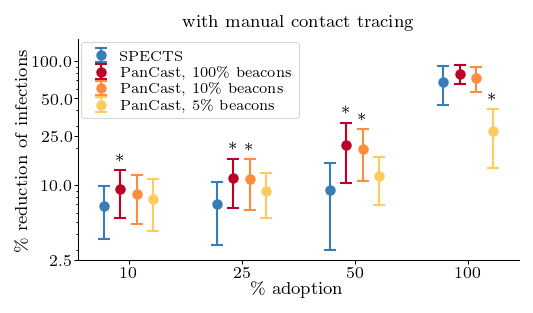

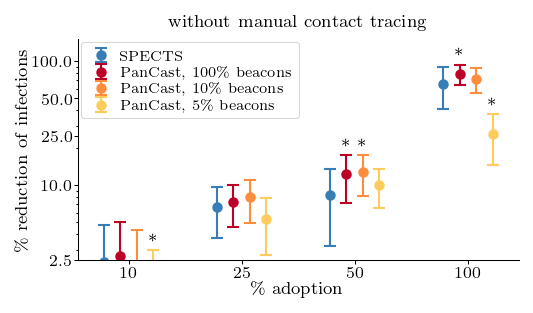

In [57]:
# Box plots
# Main results section, environmental information
sig_options = {'lhs_xshift': 0.013, 
            'rhs_xshift': 0.13, 
            'height': 0.1,
           'same_height': False}

for manual_tracing, title in zip([True, False], ['with manual contact tracing', 'without manual contact tracing']):
    plot_relative_reduction_multiple_summaries(
        country='GER', 
        area='TU', 
        mode='cumu_infected',
        title=title,
        ps_adoption=[1.0, 0.5, 0.25, 0.1],
        beacon_proportions=[1.0, 0.1, 0.05],
        summary_indices=[1, 2, 3, 5],
        isolation_cap=0.1,
        manual_tracing=manual_tracing,
        show_spect_with_beacons=False,
        colors=['#377eb8', '#bd0026', '#fd8d3c', '#fecc5c', '#ffffb2'],
        ylim=[2.5,150],
        show_significance='no_bars',
        sig_options=sig_options,
        box_plot=True,
        log_yscale=True,
        commithash='32717f3'
    )
    
!bash crop_pdfs.sh plots/comparison-*.pdf

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

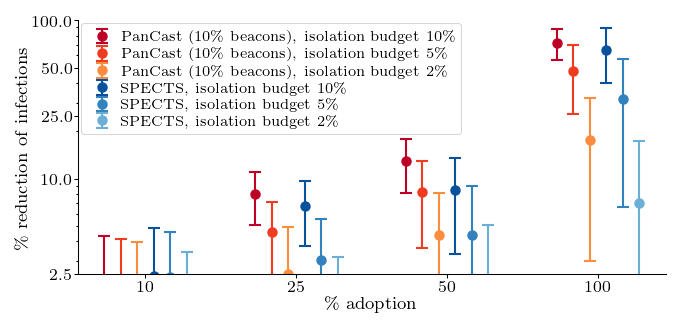

In [41]:
def plot_relative_reduction_isolation_cap_multi_summary(*, country, area, mode, ps_adoption, beacon_proportion, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            isolation_caps=None, ylim=None, box_plot=False, summary_indices=[1,2,3,4,5],
                            sig_bars=False, commithash=None):
    
    ps_adoption = np.sort(ps_adoption)
    if box_plot:
        LINE_WIDTH = 7.0
        COL_WIDTH = 3.333
        # figsize = (LINE_WIDTH*2/3, COL_WIDTH*2/3)
        figsize = (LINE_WIDTH * 8/12, 1.15 * LINE_WIDTH / 3 * 4.5/6)
    else:
        figsize = lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
    
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    delta_manual_tracing = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.5)
            
    
    plot_filename = (f'comparison-isolation-caps-multi-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-box_plot={box_plot}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    
    
    paths = []
    titles = []
    
    
    for cap in isolation_caps:
        paths.append([[f'pancast-tracing-siteinfo-{idx}-{country}-{area}-{commithash}/'
                      f'pancast-tracing-siteinfo-{idx}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'-beta_dispersion=10.0'
                      f'-isolation_cap={cap}'
                      f'-normalization=1.75'
                      '.pk' for idx in summary_indices]
                      for p_adoption in ps_adoption])
                     
        #titles.append(f'PanCast, {int(beacon_proportion*100)}\% beacons, isolation budget {int(cap*100)}\%')
        titles.append(f'PanCast ({int(beacon_proportion*100)}\% beacons), isolation budget {int(cap*100)}\%')



        
    for cap in isolation_caps:
        paths.append([[f'spect-tracing-siteinfo-{idx}-{country}-{area}-{commithash}/'
                     f'spect-tracing-siteinfo-{idx}-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'-beta_dispersion=10.0'
                     f'-isolation_cap={cap}'
                      f'-normalization=1.75'
                     '.pk' for idx in summary_indices]
                      for p_adoption in ps_adoption])
        
        titles.append(f'SPECTS, isolation budget {int(cap*100)}\%')
        
    baseline_path = [f'spect-tracing-siteinfo-{idx}-{country}-{area}-{commithash}/'
                     f'spect-tracing-siteinfo-{idx}-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'#{p_recall}'
                     f'-p_manual_reachability=0.0'#{p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'-beta_dispersion=10.0'
                     f'-isolation_cap=0.0'
                     f'-normalization=1.75'
                     f'.pk'  for idx in summary_indices]

    
    colors = ['#bd0026', '#f03b20', '#fd8d3c', '#08519c', '#3182bd', '#6baed6', ]
    
    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   labels=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   log_xscale=True,
                                   log_yscale=True,
                                   sig_bars=sig_bars,
                                   combine_summaries=True,
                                   ylim=ylim,
                                   colors=colors,
                                   box_plot=box_plot,
                                   filename=plot_filename,
                                   figsize=figsize,
                                   figformat='neurips-double',
                                   legend_is_left=True)


    
# SI results section, environmental information, dependence on isolation caps
plot_relative_reduction_isolation_cap_multi_summary(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportion=0.1,
    isolation_caps=[0.1, 0.05, 0.02],
    summary_indices=[1, 2, 3, 4, 5],
    ylim=[2.5,100],
    box_plot=True,
    sig_bars=False,
    manual_tracing=False,
    commithash='32717f3'
)

# Statistics and playground

In [ ]:
def show_summary_over_time():
    
    country = 'GER'
    area = 'TU'
    commithash = '43d4464'
    
    
    p_adoption = 1.0
    beacon_proportion = 1.0
    beacon_mode = 'visit_freq'
    show_spect_with_beacons = False
    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    cap = 0.05
    
    paths = [f'pancast-tracing-siteinfo-{country}-{area}-{commithash}/'
          f'pancast-tracing-siteinfo-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon={show_spect_with_beacons}'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          f'-beta_dispersion=10.0'
          f'-isolation_cap={cap}.pk']
    
    labels = ['ads']
    
    plot_filename = f'test'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=labels,
        quantity='infected',
        mode='cumulative',
        colors=['#31a354', '#74c476'],
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=False)
    
show_summary_over_time()



In [ ]:
def get_tracing_probability2(mode, p_adoption, p_manual_reachability, p_recall, p_beacon=0.0):
    if mode == 'SPECTs':
        p_digital = p_adoption ** 2
        p_manual = p_recall * p_manual_reachability * (1 - p_digital)
        p_tracing = p_digital + p_manual
    elif mode == 'PanCast':
        p_digital = (p_adoption ** 2) * p_beacon
        p_manual = p_recall * p_manual_reachability * (1 - p_digital)
        p_digital_manual = p_beacon * p_adoption * p_manual_reachability * (1 - p_digital - p_manual)
        p_manual_digital = p_beacon * p_adoption * p_recall  * (1 - p_digital - p_manual - p_digital_manual)
        p_tracing = p_digital + p_manual + p_digital_manual + p_manual_digital
        #print(p_digital, p_digital_manual, p_manual_digital, p_manual)
    else:
        NotImplementedError('`mode` can only be in ["SPECTs", "PanCast"]')
    return p_tracing


p_tracable = get_tracing_probability2('PanCast', 
                                     p_adoption=0.9, 
                                     p_manual_reachability=0.9999,
                                     p_recall=0.9999, 
                                     p_beacon=0.9)
print(p_tracable)

In [ ]:
from tabulate import tabulate

def show_roc_statistics(threshold_indices, beta_dispersion=10.0, commithash='baf7764'):

    assert beta_dispersion in [10.0, 'custom']

    summary = load_condensed_summary(f'PanCast/beacon-environment-GER-TU-{commithash}/'
                              f'beacon-environment-GER-TU'
                              f'-beacon=all'
                              f'-p_adoption=1.0'
                              f'-beta_dispersion={beta_dispersion}'
                              '.pk')

    tracing_stats = summary['tracing_stats']
    thresholds = list(tracing_stats.keys())

    betas = {'custom': {'sites': {'total': 0, 'education': 0.02731594725044837, 'social': 0.05463189450089674, 'bus_stop': 0.0018210631500298917, 'office': 0.03642126300059783, 'supermarket': 0.018210631500298915},
                        'no_sites': {'total': 0, 'education': 0.04027511551976204, 'social': 0.04027511551976204, 'bus_stop': 0.04027511551976204, 'office': 0.04027511551976204, 'supermarket': 0.04027511551976204}
                        },
             10.0: {'no_sites': {'total': 0, 'education': 0.04027511551976204, 'social': 0.04027511551976204, 'bus_stop': 0.04027511551976204, 'office': 0.04027511551976204, 'supermarket': 0.04027511551976204},
                    'sites': {'total': 0, 'education': 0.008195195098129743, 'social': 0.08195195098129741, 'bus_stop': 0.0008195195098129743, 'office': 0.008195195098129743, 'supermarket': 0.008195195098129743}
                    }
            }

    betas = betas[beta_dispersion]

    for thres in threshold_indices:
        thres = thresholds[thres]
        print()
        print()
        print('Threshold: ', thres)
        for sites in ['no_sites', 'sites']:
            values = []
            print()
            if sites == 'no_sites':
                print('SPECTS')
            else:
                print('PanCast')
            print()
            for sitetype in tracing_stats[thres].keys():
                infected = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean()
                not_infected = tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
                isolated = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
                not_isolated = tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean()
                tpr = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() / infected
                fpr = tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean() / not_infected

                if sitetype == 'stats':
                    sitetype = 'total'
                values.append([sitetype, "{:.4f}".format(betas[sites][sitetype]), int(infected), int(not_infected), int(isolated), tpr, fpr])
            print(tabulate(values, headers=['Sitetype', 'beta', 'infected', 'not infected', 'isolated', 'TPR', 'FPR']))
            
show_roc_statistics([10], commithash='43d4464')